# Load modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from dateutil import tz

from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample

%matplotlib inline

# Define runoff functions
from hydrology import scs_composite_CN, scs_excess_precipitation, scs_uh_runoff, precip_data, scs_excess_precipitation

# Load pipedream model information 

In [2]:

## Load pipedream model information 
superjunctions = pd.read_csv('../data/waller_superjunctions.csv', index_col=0)  
superlinks = pd.read_csv('../data/waller_creek_superlinks.csv', index_col=0) 
subbasins = pd.read_csv('../data/Waller_HMS_model_data.csv', index_col=0)


# Specify simulation parameters
# Unit conversions
m_per_ft = 0.3048
ft_per_mi = 5280.
in_per_ft = 12.
s_per_min = 60
ns_per_s = 1e9

# Manual edits to model
superlinks.loc[20, ['g2', 'g3']] = 5.6, 6.3
superlinks.loc[21, ['g2', 'g3']] = 3.7, 3.977146367746631
superlinks.loc[22, ['g2', 'g3']] = 0., 7.777146367746631
superlinks.loc[23, ['g2', 'g3']] = 0., 8.3714367746631
superlinks['C_uk'] = 0.
superlinks['C_dk'] = 0.

superjunctions.loc[16, ['z_inv']]=147.9

# Simulation params
sample_interval = 30

site_junction_name = 'J_WLR18_COMB_HEMP'
site_link_name = 'R_WLR16'
site_junction_index = 14
site_link_index = 21

# Load unit hydrograph
# Load dimensionless unit hydrograph
uh__dimless = pd.read_csv('../data/unit_hydrograph.csv')
# Drop unnecessary columns and rows
uh__dimless = uh__dimless[['time ratios', 'discharge ratios']].dropna()
dt = 10

# Set up Kalman filtering parameters
n = len(superjunctions)
p = n
m = 4

process_std_dev = 1e-2
measurement_std_dev = 2e-4

H_kal = np.zeros((m, n))
H_kal[0, 13] = 1.
H_kal[1, 14] = 1.
H_kal[2, 15] = 1.
H_kal[3, 16] = 1.
Qcov = (process_std_dev**2)*np.eye(p)
Rcov = (measurement_std_dev**2)*np.eye(m)

C_kal = np.zeros((n, p))
C_kal[np.arange(n), np.arange(p)] = 1.

# forecast precipitation data

In [3]:
forecast = pd.read_csv('../data/rainfall_data/precip__in_forecast.csv', index_col=0)
forecast.index = pd.to_datetime(pd.Series(forecast.index))
forecast = forecast.tz_localize('UTC')
# Compute inches of precipitation for desired sample interval
forecast_precip_in = sample_interval * forecast['precip_rate__in_per_s'].resample(f'{sample_interval}s').mean().interpolate()


# Compute runoff into each superjunction

In [4]:
# Compute runoff into each superjunction
def Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: 0.):
    keepGoing=True
    while keepGoing:
        try:
            Q_in = {}
            CNs = []
            # Manual edits to hydrology params
            lag_time_adjust_ratio = 1.0
            CN_adjust_ratio = 1.0


            # For each subbasin...
            for i in range(len(subbasins)):
                P_now = 0.
                # Load subbasin parameters
                CN_C = subbasins['Curve Number'][i]
                A_Imp = subbasins['Impervious Percent'][i]
                area__sq_mi = subbasins['Area (mi2)'][i]
                downstream = subbasins['Downstream'][i]
                lag_time__min = subbasins['Lag Time'][i] * lag_time_adjust_ratio

                # Compute composite curve number
                CN = scs_composite_CN(CN_C, A_Imp) * CN_adjust_ratio
                CN = min(CN, 98)

                # Compute excess precipitation
                excess_precip_cum__in, excess_precip__in, P_now = scs_excess_precipitation(precip__in, CN,P_now,decay_function=decay_function)

                # Compute runoff using unit hydrograph
                runoff__cms = scs_uh_runoff(excess_precip__in, uh__dimless, area__sq_mi, sample_interval,lag_time__min)
                Q_in[downstream] = runoff__cms

            # Format flow input as DataFrame
            Q_in = pd.DataFrame.from_dict(Q_in)
            # Add flow input for missing sites
            Q_in['UPSTREAM_WALLER'] = Q_in['R_WLR01']
            Q_in['UPSTREAM_HEMPHILL'] = Q_in['R_HEM01']
            Q_in[[name for name in superjunctions['name'] if not name in Q_in.columns]] = 0.
            # Ensure flow input is only for superjunctions specified in table
            Q_in = Q_in[superjunctions['name'].tolist()]
            # Remove NaN values
            Q_in = Q_in.fillna(0.)
            # Copy flow input with original timestamps
            Q_in_orig = Q_in.copy()
            # Convert flow input index to integer index starting with zero
            Q_in.index = Q_in.index.astype(int) / 1e9
            Q_in.index -= Q_in.index.min()
            keepGoing=False
        
        except ValueError:
            keepGoing=True
        except KeyError :
            keepGoing=True
        except AssertionError:
            keepGoing=True


    return excess_precip__in,Q_in,P_now

# Load Sensor depth data

In [5]:
bridge_2 = pd.read_csv('../data/sensor_measurements/bridge2_classification.csv', index_col=0)['Bridge2']
bridge_2.index = pd.to_datetime(bridge_2.index)
bridge_3 = pd.read_csv('../data/sensor_measurements/bridge3_classification.csv', index_col=0)['Bridge3']
bridge_3.index = pd.to_datetime(bridge_3.index)
bridge_4 = pd.read_csv('../data/sensor_measurements/bridge4_classification.csv', index_col=0)['Bridge4']
bridge_4.index = pd.to_datetime(bridge_4.index)
bridge_5 = pd.read_csv('../data/sensor_measurements/bridge5_classification.csv', index_col=0)['Bridge5']
bridge_5.index = pd.to_datetime(bridge_5.index)

In [7]:

codisp = {}
# Create array for detected outliers
is_outlier = []
is_outliers = []
# Create a dict to store anomaly score of each point
avg_codisp = {}

start_date='20230404'
end_date='20230520'



final_data={}
P_now = 0


precip__in = forecast_precip_in.loc[start_date:end_date]

if precip__in.empty != True:
    excess_precip__in,Q_in,P_now=Model_initialization(precip__in,subbasins,P_now,decay_function=lambda x: (1 -0.9974)*x)

    measurements = pd.concat([bridge_2.resample('5min').mean().interpolate(method='nearest'),
                              bridge_5.resample('5min').mean().interpolate(method='nearest'),
                          bridge_3.resample('5min').mean().interpolate(method='nearest'),
                          bridge_4.resample('5min').mean().interpolate(method='nearest')
                             ], axis=1).interpolate()
    measurements = measurements.fillna(method='backfill')
    measurements = measurements + superjunctions.loc[[13, 14, 15, 16], 'z_inv'].values
    measurements.index = measurements.index - precip__in.index.min()
    measurements.index = measurements.index.astype(int) / 1e9  


    superlink = SuperLink(superlinks, superjunctions,internal_links=30, mobile_elements=True)


    H_j = []
    h_Ik = []
    Q_uk = []
    Q_dk = []
    residuals = []
    scores = []

    # Set constant timestep (in seconds)

    # Add constant baseflow
    baseflow = 0.35e-3  * np.ones(superlink._h_Ik.size)

    # Create simulation context manager
    with Simulation(superlink, Q_in=Q_in, Qcov=Qcov, Rcov=Rcov,
                C=C_kal, H=H_kal, interpolation_method='nearest') as simulation:
        simulation.model.load_state(final_data)
        # While simulation time has not expired...
        while simulation.t <= simulation.t_end:
            # Step model forward in time
            simulation.step(dt=dt, num_iter=8, Q_Ik=baseflow)
            # Get measured value
            next_measurement = interpolate_sample(simulation.t,
                                                  measurements.index.values,
                                                  measurements.values,
                                                  method=0)
            # Apply Kalman filter with measured value
            H = H_kal
            C = C_kal
            Z_next = next_measurement
            P_x_k_k = simulation.P_x_k_k
            A_1, A_2, b = simulation.model._semi_implicit_system(_dt=dt)
            I = np.eye(A_1.shape[0])
            y_k1_k = b
            A_1_inv = np.linalg.inv(A_1)
            H_1 = H @ A_1_inv
            residual = (Z_next - H_1 @ y_k1_k)
            residuals.append(residual)



            cond = residual**2 > 0.5


            if (cond).any():
                H_mod = H[~cond]
                H_1 = H_mod @ A_1_inv
                Rcov_mod = Rcov[~cond][:, ~cond]
                Z_next = Z_next[~cond]
            else:
                H_mod = H
                Rcov_mod = Rcov
            P_y_k1_k = A_2 @ P_x_k_k @ A_2.T + C @ Qcov @ C.T
            L_y_k1 = P_y_k1_k @ H_1.T @ np.linalg.inv((H_1 @ P_y_k1_k @ H_1.T) + Rcov_mod)
            P_y_k1_k1 = (I - L_y_k1 @ H_1) @ P_y_k1_k
            b_hat = y_k1_k + L_y_k1 @ (Z_next - H_1 @ y_k1_k)
            P_x_k1_k1 = A_1_inv @ P_y_k1_k1 @ A_1_inv.T
            #if score < 1e-7:
            simulation.P_x_k_k = P_x_k1_k1
            simulation.model.b = b_hat
            simulation.model.iter_count -= 1
            simulation.model.t -= dt
            simulation.model._solve_step(dt=dt)

            #simulation.kalman_filter(next_measurement, dt=dt)
            simulation.model.reposition_junctions()
            # Print progress bar
            simulation.print_progress()
            # Save states
            H_j.append(simulation.model.H_j.copy())
            h_Ik.append(simulation.model.h_Ik.copy())
            Q_uk.append(simulation.model.Q_uk.copy())
            Q_dk.append(simulation.model.Q_dk.copy())

    time_index = pd.date_range(start=excess_precip__in.index.min(), 
                                       periods=len(H_j), 
                                       freq=f'{dt}s')

    # Convert saved states to dataframes
    H_j = pd.DataFrame(np.vstack(H_j), index=time_index, columns=superjunctions['name'])
    h_Ik = pd.DataFrame(np.vstack(h_Ik), index=time_index)
    Q_uk = pd.DataFrame(np.vstack(Q_uk), index=time_index, columns=superlinks['name'])
    Q_dk = pd.DataFrame(np.vstack(Q_dk), index=time_index, columns=superlinks['name'])
    residuals = pd.DataFrame(np.vstack(residuals), index=time_index, columns=['J_WLR16_32ND', 'J_WLR18_COMB_HEMP',
                                                                           'J_WLR19_23RD','J_WLR20_TRINITY'])


    # Compute depth
    h_j = H_j - simulation.model._z_inv_j
    final_data=simulation.model.states

    final_data['t']=0



h_j_kf = h_j.copy()




[==================================================] 100.0% [2082.74 s]

# J_WLR18_COMB_HEMP

In [8]:
site_junction_name = 'J_WLR18_COMB_HEMP'
site_junction_index = 14

(19451.0, 19497.0)

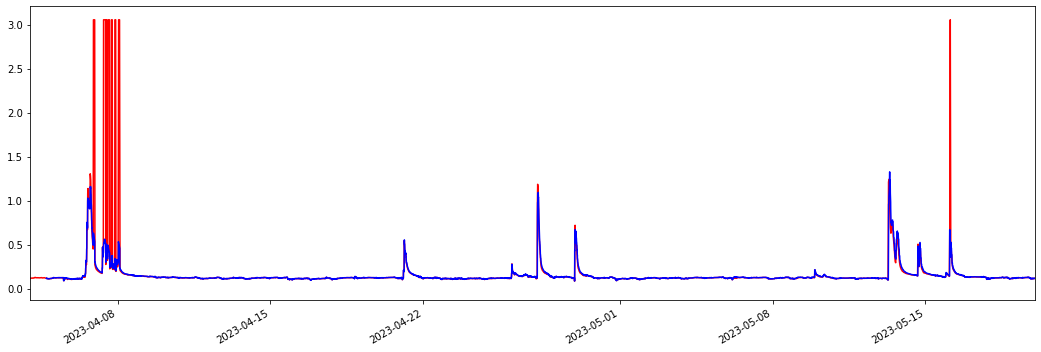

In [9]:
fig, ax = plt.subplots(figsize=(18, 6))
bridge_5.plot(ax=ax, c='r')
h_j[site_junction_name].plot(ax=ax, label='model', c='b')
plt.xlim(start_date, end_date)

(1680566400.0, 1684540800.0)

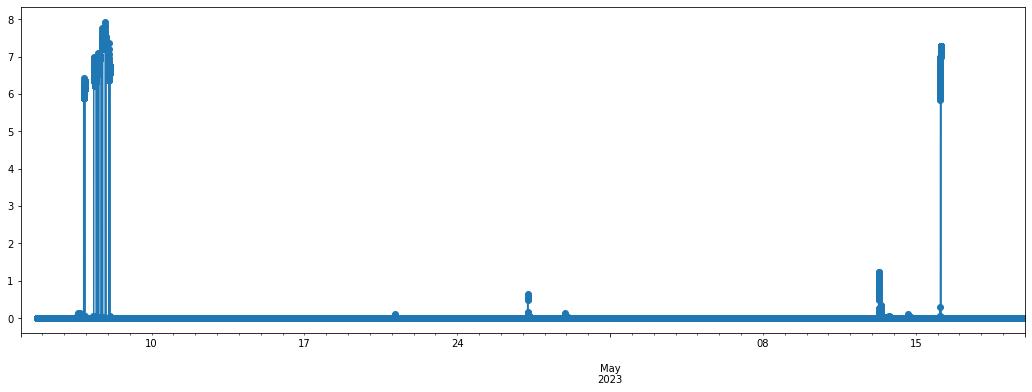

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))
(residuals**2)[site_junction_name].plot(ax=ax, marker='o')
plt.xlim(start_date, end_date)

# Save model_kf simulation and residuals

In [ ]:

# h_j_kf['J_WLR18_COMB_HEMP'].to_csv('h_j_kf_h2_check.csv')
# (residuals**2).to_csv('residual_check.csv')